In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
cleaned_data = pd.read_csv('Remove_Correlated_Columns.csv')

# Load the labeled data
labeled_data = pd.read_csv('labeled_cluster_exoplanet_data.csv')

# Merge to add the Cluster column
merged_data = pd.merge(cleaned_data, labeled_data[['Planet Name', 'Cluster']], on='Planet Name', how='left')

# Check the merged data
print("Merged Data Shape:", merged_data.shape)
print("Number of NaN values in Cluster after merge:", merged_data['Cluster'].isna().sum())


Merged Data Shape: (5785, 44)
Number of NaN values in Cluster after merge: 0


In [2]:
# Define habitability ranges based on scientific criteria
habitability_criteria = {
    'Insolation Flux': (0.5, 1.5),
    'Equilibrium Temperature': (273, 373),
    'Planet Radius (Earth Radii)': (0.5, 1.5),
    'Planet Density': (3, float('inf')),
    'Star Age': (1, 10),
    'Star Mass': (0.8, 1.2),
    'Metallicity': (0.1, 1.0),
    'Orbital Period': (0.5, 2),
    'Orbital Eccentricity': (0, 0.2)
}

# Function to calculate distance from habitability criteria
def calculate_habitability_distance(df, criteria):
    distances = {}
    for feature, (low, high) in criteria.items():
        if feature in df.columns:
            distances[feature] = np.where(
                df[feature] < low,
                low - df[feature],
                np.where(df[feature] > high, df[feature] - high, 0)
            )
        else:
            distances[feature] = np.zeros(len(df))
    return pd.DataFrame(distances)

# Calculate distances for each criterion
habitat_distances = calculate_habitability_distance(merged_data, habitability_criteria)


In [3]:
# Identify overlapping columns and drop them from merged_data
overlapping_columns = set(merged_data.columns) & set(habitat_distances.columns)
merged_data_cleaned = merged_data.drop(columns=overlapping_columns)

# Combine the distances with the cleaned merged data
results = pd.concat([merged_data_cleaned, habitat_distances], axis=1)

# Calculate total distance from habitability
results['Total Distance from Habitability'] = results[list(habitability_criteria.keys())].sum(axis=1)


In [4]:
# Classify habitability using the corrected terminology
def classify_habitability(row):
    distance = row['Total Distance from Habitability']
    if distance <= 500:
        return 'Certain Habitability'
    elif distance <= 2000:
        return 'Likely Habitability'
    elif distance <= 10000:
        return 'Possible Habitability'
    else:
        return 'Uninhabitable'

results['Habitability Classification'] = results.apply(classify_habitability, axis=1)


In [5]:
# Define a mapping for clusters
cluster_names = {
    0: 'Photometric-Dominated Planets',
    1: 'Galactic Spatial Orientation',
    2: 'Measurement-Rich Planets',
    3: 'Spectroscopic-Focused Exoplanets'
}

# Replace the Cluster numbers with descriptive names
results['Cluster'] = results['Cluster'].replace(cluster_names)


In [6]:
# Sort planets by total distance and keep the result in a new DataFrame
results_sorted = results.sort_values(by='Total Distance from Habitability')

# Print top results with new cluster names
top_habitable_planets = results_sorted.head(10)
print(top_habitable_planets[['Planet Name', 'Total Distance from Habitability', 'Habitability Classification', 'Cluster']])


        Planet Name  Total Distance from Habitability  \
4209   Kepler-438 b                          0.260000   
4325         K2-3 d                          0.507000   
5213  Kepler-1410 b                          0.540000   
665       TOI-700 d                          0.560000   
185       TOI-700 e                          0.578668   
5322   Kepler-296 e                          0.640000   
3813        K2-72 e                          0.692692   
4085       GJ 273 b                          0.709177   
939    Kepler-138 e                          0.770000   
4836   Kepler-283 c                          0.794000   

     Habitability Classification                           Cluster  
4209        Certain Habitability     Photometric-Dominated Planets  
4325        Certain Habitability      Galactic Spatial Orientation  
5213        Certain Habitability     Photometric-Dominated Planets  
665         Certain Habitability      Galactic Spatial Orientation  
185         Certain Habitab

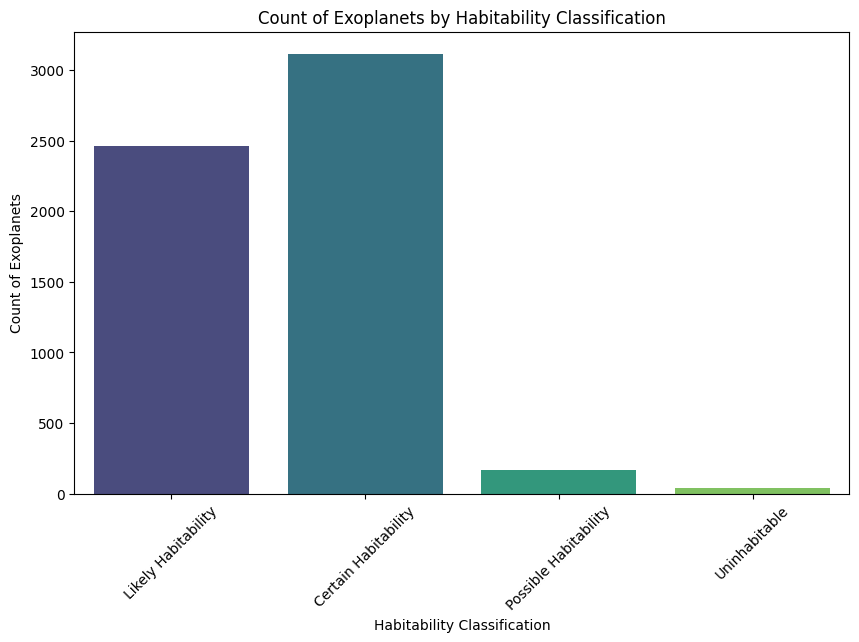

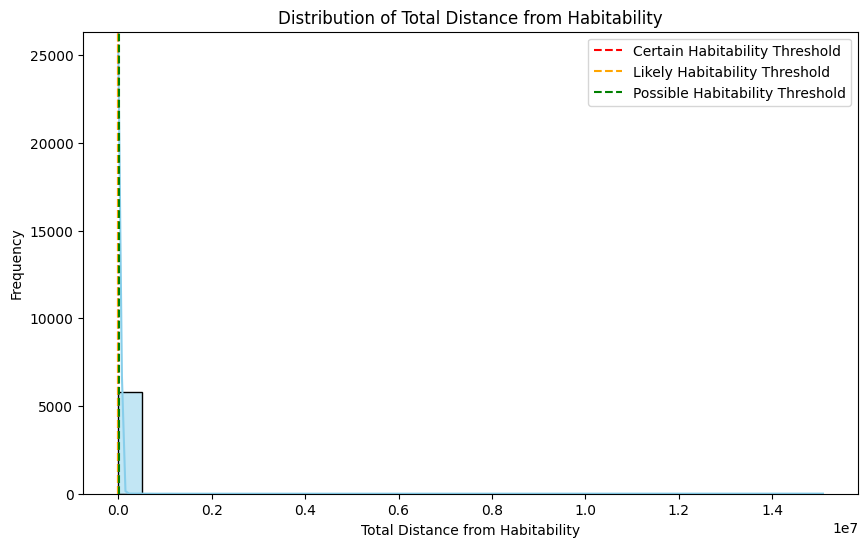

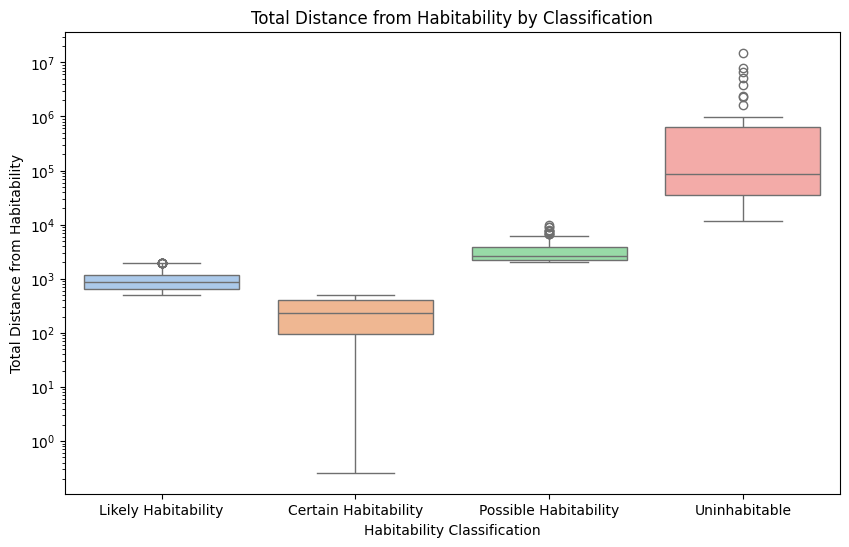

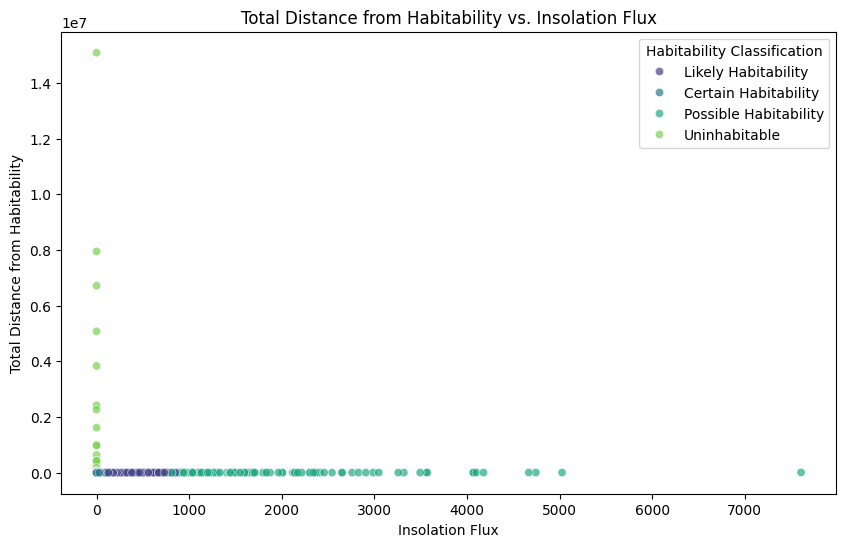

In [7]:
# Count plot of habitability classification
plt.figure(figsize=(10, 6))
sns.countplot(x='Habitability Classification', data=results, hue='Habitability Classification', palette='viridis', legend=False)
plt.title('Count of Exoplanets by Habitability Classification')
plt.xlabel('Habitability Classification')
plt.ylabel('Count of Exoplanets')
plt.xticks(rotation=45)
plt.show()

# Distribution plot of Total Distance from Habitability
plt.figure(figsize=(10, 6))
sns.histplot(results['Total Distance from Habitability'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Distance from Habitability')
plt.xlabel('Total Distance from Habitability')
plt.ylabel('Frequency')
plt.axvline(x=500, color='red', linestyle='--', label='Certain Habitability Threshold')
plt.axvline(x=2000, color='orange', linestyle='--', label='Likely Habitability Threshold')
plt.axvline(x=10000, color='green', linestyle='--', label='Possible Habitability Threshold')
plt.legend()
plt.show()

# Box plot of total distance from habitability by classification
plt.figure(figsize=(10, 6))
sns.boxplot(x='Habitability Classification', y='Total Distance from Habitability', data=results, hue='Habitability Classification', palette='pastel', legend=False)
plt.title('Total Distance from Habitability by Classification')
plt.xlabel('Habitability Classification')
plt.ylabel('Total Distance from Habitability')
plt.yscale('log')  # Log scale for better visibility
plt.show()

# Scatter plot of Total Distance from Habitability vs. Insolation Flux
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='Insolation Flux', y='Total Distance from Habitability', hue='Habitability Classification', palette='viridis', alpha=0.7)
plt.title('Total Distance from Habitability vs. Insolation Flux')
plt.xlabel('Insolation Flux')
plt.ylabel('Total Distance from Habitability')
plt.legend(title='Habitability Classification')
plt.show()


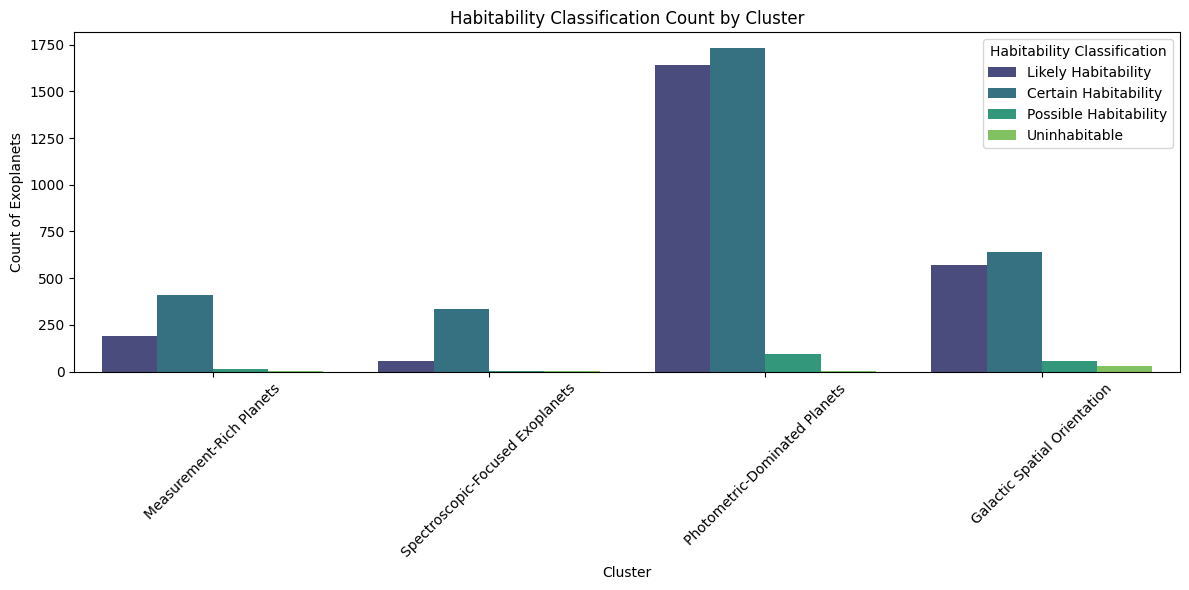

<Figure size 1200x600 with 0 Axes>

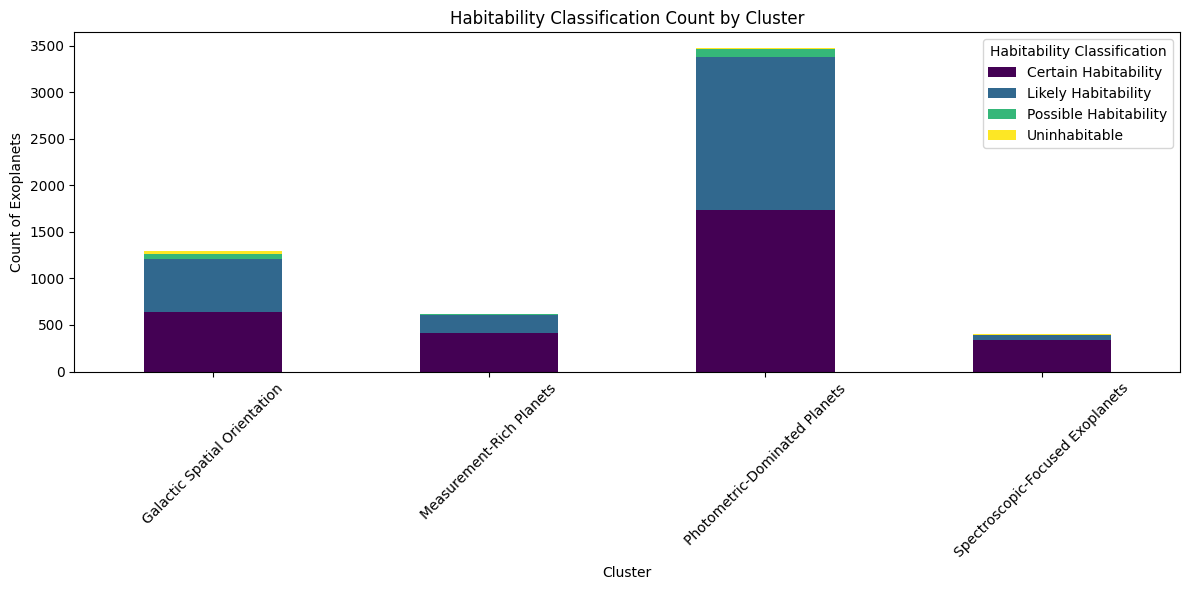

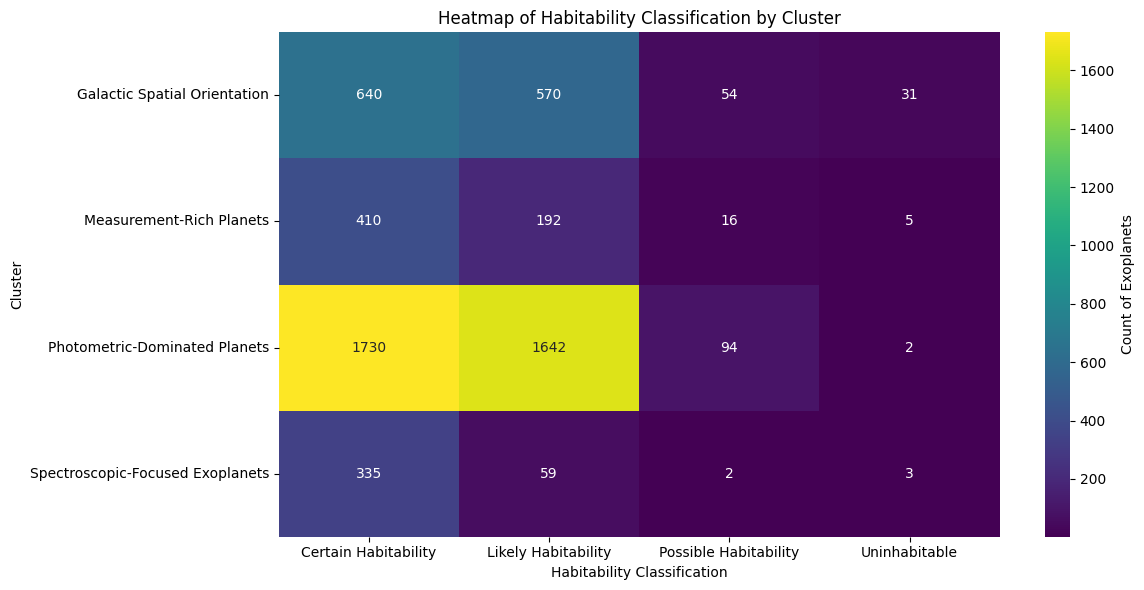

In [8]:
# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.countplot(data=results, x='Cluster', hue='Habitability Classification', palette='viridis')
plt.title('Habitability Classification Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count of Exoplanets')
plt.xticks(rotation=45)
plt.legend(title='Habitability Classification')
plt.tight_layout()
plt.show()

# Count of classifications by cluster
classification_counts = results.groupby(['Cluster', 'Habitability Classification']).size().unstack(fill_value=0)

# Create a stacked bar plot
plt.figure(figsize=(12, 6))
classification_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Habitability Classification Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count of Exoplanets')
plt.xticks(rotation=45)
plt.legend(title='Habitability Classification')
plt.tight_layout()
plt.show()

# Create a heatmap of classification counts by cluster
plt.figure(figsize=(12, 6))
sns.heatmap(classification_counts, annot=True, fmt='d', cmap='viridis', cbar_kws={'label': 'Count of Exoplanets'})
plt.title('Heatmap of Habitability Classification by Cluster')
plt.xlabel('Habitability Classification')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()


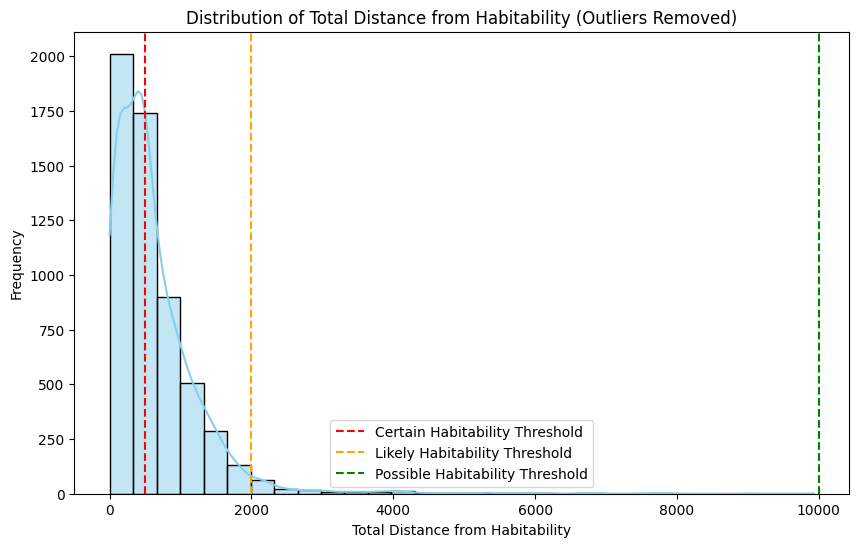

In [9]:
# Removing outliers for better visualization
filtered_results = results[results['Total Distance from Habitability'] < 10000]  

plt.figure(figsize=(10, 6))
sns.histplot(filtered_results['Total Distance from Habitability'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Distance from Habitability (Outliers Removed)')
plt.xlabel('Total Distance from Habitability')
plt.ylabel('Frequency')
plt.axvline(x=500, color='red', linestyle='--', label='Certain Habitability Threshold')
plt.axvline(x=2000, color='orange', linestyle='--', label='Likely Habitability Threshold')
plt.axvline(x=10000, color='green', linestyle='--', label='Possible Habitability Threshold')
plt.legend()
plt.show()
